In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

!pip install --q japanize_matplotlib
import japanize_matplotlib

%matplotlib inline
plt.style.use("ggplot")

! pip install --q plotly
import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import mean_squared_error


from google.cloud import bigquery
# プロジェクトIDの指定
project_id = 'inunaki'
# authが終わっていたら普通にクライアント認証は通る
client = bigquery.Client(project=project_id)

import warnings
warnings.simplefilter('ignore')


ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/conda/etc/jupyter/nbconfig/notebook.d/jupyterlab-plotly.json'
Consider using the `--user` option or check the permissions.



In [3]:
# 宣言した人数
query = """
-- 前日のみ更新するためにコードを書く
CREATE TEMPORARY FUNCTION to_date2() AS (CURRENT_DATE("Asia/Tokyo") - 2);
-- 期間を絞る
CREATE TEMPORARY FUNCTION to_date() AS (DATE(2023, 8, 31));
CREATE TEMPORARY FUNCTION to_date_start_date() AS(DATE(2023, 7, 14));

  -- 実際に購入まで行った顧客
WITH base AS(
  SELECT  salesday, COALESCE(customercd_new, posid.customercd) AS customercd, jan, SUM(salesamount)AS sales_amt, SUM(salescnt)AS cnt, salestime
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail` posid 
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
  ON posid.customercd = ii.customercd
  WHERE salesday BETWEEN to_date_start_date() AND to_date() 
  AND posid.customercd <> "0"
  GROUP BY salesday, customercd, jan, salestime
 ),
 tmp_data AS(
  SELECT salesday, salestime, customercd, CAST(jan AS INT64) jan, sales_amt, cnt
  FROM base 
),
-- janを追加する
result AS(
  SELECT salesday, salestime, customercd, 
         coupon_name, app_jan.jan, kubun, haisin_tuki, end_tuki, sales_amt, cnt, huyo_point, coupon_id, types
  FROM tmp_data
  -- 抽選は外して出す
  JOIN (SELECT * FROM `inunaki.dst_workspace.app_cupon_jan` WHERE types <> "キャンペーン・クーポン（抽選）" AND types <> "キャンペーン（抽選）" )  app_jan
  ON tmp_data.jan = app_jan.jan
),
-- アプリクーポン宣言ベースデータ 
app_sengen_base AS(
  SELECT  dt, month, customer_id, sync_dttm, coupon_name, CAST(tmp.coupon_id AS INT64) AS coupon_id, CONCAT(dt, "_", coupon_name) AS coupon_name2, 1 AS sengen_flg
  -- 日付を変更する
  FROM(
  SELECT  DATE(year,month,dt) AS dt, month, customer_id, sync_dttm, coupon_name, CAST(coupon_id AS INT64) AS coupon_id
  FROM `inunaki.dwd_action_0001.dwd_karte_user_use_coupon`
  ) tmp
  -- 抽選は外して出す
  JOIN (SELECT DISTINCT coupon_id FROM `inunaki.dst_workspace.app_cupon_jan` WHERE types <> "キャンペーン・クーポン（抽選）" AND types <> "キャンペーン（抽選）")  app_jan
  ON tmp.coupon_id = app_jan.coupon_id
  WHERE dt BETWEEN to_date_start_date() AND to_date()
),
-- 宣言した日もしくは、それ以降に実際に購入した顧客
sengen_konyu AS(
SELECT salesday, salestime, customercd, sync_dttm, dt,
         result.coupon_name, jan, kubun, haisin_tuki, end_tuki, sales_amt, cnt, huyo_point, types, coupon_name2, 
         CASE
         WHEN (salestime >= sync_dttm) AND (salesday <= end_tuki)THEN 1
         WHEN salesday = dt THEN 1
         ELSE 0 
         END AS riyo_flg,

         CASE
         WHEN types = "一回限り" THEN 1
         ELSE cnt
         END AS coupon_count
FROM result
JOIN app_sengen_base
ON result.customercd = app_sengen_base.customer_id
AND result.coupon_id = app_sengen_base.coupon_id
)--,
-- 1回のみの使用なのでそれを絞る
-- result_data AS(
  SELECT salesday2, EXTRACT(MONTH FROM  DATE (salesday2) ) AS month, customercd, coupon_name2, AVG(huyo_point) AS huyo_point, AVG(coupon_count) AS coupon_count,
  FROM(SELECT salesday,FIRST_VALUE(salesday) OVER(PARTITION BY customercd,coupon_name2  ORDER BY salesday) AS salesday2,
              FIRST_VALUE(coupon_count) OVER(PARTITION BY customercd,coupon_name2  ORDER BY salesday) AS coupon_count,
              customercd, coupon_name2,huyo_point 
        FROM sengen_konyu WHERE riyo_flg = 1)
  GROUP BY salesday2, customercd, coupon_name2
-- )
-- SELECT dt, month, customer_id, sync_dttm, coupon_name, sengen_flg
-- FROM app_sengen_base
"""

#データフレームに変換
df = client.query(query).to_dataframe()

In [4]:
df = df.rename(columns={"salesday2":"dt","customercd":"customer_id"})
df.head()

,dt,month,customer_id,coupon_name2,huyo_point,coupon_count
0,2023-07-14,7,8b899a4cc1a684358358d9a5a77ae283,2023-07-14_レッドブル_250ml,20.0,4.0
1,2023-07-14,7,8256a6c0aa99612e3079696cd39e466a,2023-07-14_プチシリーズ_各種,200.0,1.0
2,2023-07-14,7,267edf2d5e68237e5e8d48f9841d7cc6,2023-07-14_ミツカン追いがつおつゆ_1L（セット売り商品は対象外）,30.0,1.0
3,2023-07-14,7,d8f6fd3a3648efb16e72505ec0b1b405,2023-07-14_プチシリーズ_各種,200.0,1.0
4,2023-07-14,7,20591d97625ce86b73c02bba49eb5f56,2023-07-14_レッドブル_250ml,20.0,1.0


In [5]:
query = """
-- 期間を絞る
CREATE TEMPORARY FUNCTION to_date() AS (DATE(2023, 8, 31));
CREATE TEMPORARY FUNCTION to_date_start_date() AS(DATE(2023, 7, 14));

SELECT  dt, month, customer_id, sync_dttm, coupon_name, CAST(tmp.coupon_id AS INT64) AS coupon_id, CONCAT(dt, "_", coupon_name) AS coupon_name2, 1 AS sengen_flg
-- 日付を変更する
FROM(
SELECT  DATE(year,month,dt) AS dt, month, customer_id, sync_dttm, coupon_name, CAST(coupon_id AS INT64) AS coupon_id
FROM `inunaki.dwd_action_0001.dwd_karte_user_use_coupon`
) tmp
-- 抽選は外して出す
JOIN (SELECT DISTINCT coupon_id FROM `inunaki.dst_workspace.app_cupon_jan` WHERE types <> "キャンペーン・クーポン（抽選）" AND types <> "キャンペーン（抽選）")  app_jan
ON tmp.coupon_id = app_jan.coupon_id
WHERE dt BETWEEN to_date_start_date() AND to_date()
"""

#データフレームに変換
df_sengen = client.query(query).to_dataframe()

In [6]:
# ホームを見た顧客
query = """
-- 期間を絞る
CREATE TEMPORARY FUNCTION to_date() AS (DATE(2023, 8, 31));
CREATE TEMPORARY FUNCTION to_date_start_date() AS(DATE(2023, 7, 14));

WITH  base AS (
    SELECT  dt, month, customer_id, sync_dttm, view_name, sex, age
    FROM (
      SELECT  DATE(year,month,dt) AS dt, month, customer_id, sync_dttm, view_name
      FROM `inunaki.dwd_action_0001.dwd_karte_supay_accesshome`
      ) tmp
    LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_info` i
    ON tmp.customer_id = i.customercd
    WHERE dt BETWEEN to_date_start_date() AND to_date()
),
-- ライフステージ人数（週）
lifestage_temp AS (
  SELECT 
    ym, customer_id,
  CASE
      WHEN single = "1" THEN "単身"
      WHEN dewks = "1" THEN "DEWKS"
      WHEN dinks = "1" THEN "DINKS"
  ELSE "老年夫婦"
  END AS lifestage,
  ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY ym DESC) AS number
  FROM `inunaki.dws_cdp_0001.dws_customer_wide_tags` lifestage
  -- 直近180日分のデータを使う
  -- WHERE ym >= lifestage_day
  WHERE ym >= "2022-04-01"
),
lifestage_data AS(
  SELECT customer_id, lifestage
  FROM lifestage_temp
  WHERE number = 1
)
SELECT dt, month, base.customer_id, sync_dttm, view_name, sex, age, lifestage
FROM base
LEFT JOIN lifestage_data
ON base.customer_id = lifestage_data.customer_id

"""
df_home = client.query(query).to_dataframe()

df_home["lifestage"] = df_home["lifestage"].fillna("不明")

In [7]:
# クーポンリストを見た顧客
query = """
-- 期間を絞る
CREATE TEMPORARY FUNCTION to_date() AS (DATE(2023, 8, 31));
CREATE TEMPORARY FUNCTION to_date_start_date() AS(DATE(2023, 7, 14));

SELECT  dt, month, customer_id, sync_dttm, view_name
FROM (
  SELECT  DATE(year,month,dt) AS dt, month, customer_id, sync_dttm, view_name
  FROM `inunaki.dwd_action_0001.dwd_karte_user_view_couponlist`
  ) tmp
WHERE dt BETWEEN to_date_start_date() AND to_date()
"""
df_copon = client.query(query).to_dataframe()

In [8]:
df_home.head()

,dt,month,customer_id,sync_dttm,view_name,sex,age,lifestage
0,2023-07-14,7,3f52b327926b604d726af9c23394ec72,2023-07-14 13:22:43.966,Home,0,60,老年夫婦
1,2023-07-14,7,50d9ac96e9dd5ba390dc1b933676d9cf,2023-07-14 18:42:28.043,Home,1,30,DINKS
2,2023-07-14,7,c35f6d3af6114adf21a35da003299b22,2023-07-14 17:01:42.919,Home,0,40,DEWKS
3,2023-07-14,7,94d6b956408f74603b336727d638e661,2023-07-14 10:06:33.198,Home,1,35,DINKS
4,2023-07-14,7,d999e1f81224fff602a75f09c4fd1f45,2023-07-14 19:34:42.399,Home,0,40,DEWKS


In [9]:
df_copon.head()

,dt,month,customer_id,sync_dttm,view_name
0,2023-07-14,7,0018be8324bc96c13b1a25f22a3344dc,2023-07-14 11:25:21.932,CouponList
1,2023-07-14,7,01551998d692982c5789bf5a73c752c6,2023-07-14 07:14:01.076,CouponList
2,2023-07-14,7,018ffcce00ddd20c96078a646aeadc9a,2023-07-14 10:13:26.330,CouponList
3,2023-07-14,7,0252e8d5d6d2d0163b3a87e1b7124134,2023-07-14 07:44:12.519,CouponList
4,2023-07-14,7,034040b1ed170f52ee4037aafd34122f,2023-07-14 07:32:56.185,CouponList


In [10]:
df_home["lifestage"].value_counts()

DEWKS    2362117
DINKS    1842284
単身       1484682
老年夫婦     1329625
不明        181802
Name: lifestage, dtype: int64

In [14]:
df_home_count = df_home.groupby(["customer_id","sex","age","lifestage"]).agg({"dt":"count"}).reset_index().rename(columns={"dt":"ホームを見た回数"})
df_copon_count = df_copon.groupby(["customer_id"]).agg({"dt":"count"}).reset_index().rename(columns={"dt":"クーポン一覧を見た回数"})
df_sengen_count = df_sengen.groupby(["customer_id"]).agg({"dt":"count"}).reset_index().rename(columns={"dt":"宣言した回数"})
df_item_count = df.groupby(["customer_id"]).agg({"dt":"count"}).reset_index().rename(columns={"dt":"クーポンを利用した回数"})

In [84]:
# 全てをマージする
df_data = df_home_count.merge(df_copon_count, on="customer_id",how="left").fillna(0)
df_data = df_data.merge(df_sengen_count, on="customer_id", how="left").fillna(0)
df_data = df_data.merge(df_item_count, on="customer_id", how="left").fillna(0)

In [85]:
df_data.head()

,customer_id,sex,age,lifestage,ホームを見た回数,クーポン一覧を見た回数,宣言した回数,クーポンを利用した回数
0,000000d6932e4969efada9ea7c48ab44,1,60,老年夫婦,2,0.0,0.0,0.0
1,000012a8cee42b5f5a1a466212863fb3,1,40,単身,6,0.0,0.0,0.0
2,0000660fa52d92be0d7d857fa7b13f76,0,50,老年夫婦,10,0.0,0.0,0.0
3,0000aa392e8053f66185c3334770c7d7,9,40,DEWKS,106,3.0,1.0,0.0
4,0000ace6c6ff48b33658be5c08e8df2f,0,45,DINKS,20,0.0,0.0,0.0


In [86]:
df_life_tmp = df_data.query("ホームを見た回数>=1").groupby(["lifestage"]).agg({"ホームを見た回数":"count"})
df_life_tmp2 = df_data.query("クーポン一覧を見た回数>=1").groupby(["lifestage"]).agg({"クーポン一覧を見た回数":"count"})
df_life_tmp3 = df_data.query("宣言した回数>=1").groupby(["lifestage"]).agg({"宣言した回数":"count"})
df_life_tmp4 = df_data.query("クーポンを利用した回数>=1").groupby(["lifestage"]).agg({"クーポンを利用した回数":"count"})

df_life = df_life_tmp.merge(df_life_tmp2, on="lifestage",how="outer").fillna(0)
df_life = df_life.merge(df_life_tmp3, on="lifestage",how="outer").fillna(0)
df_life = df_life.merge(df_life_tmp4, on="lifestage",how="outer").fillna(0)
df_life = df_life.sort_values("ホームを見た回数",ascending=False)
# 割合を調整
for i in df_life.columns:
    df_life[f"{i}の比率"] = round(df_life[i] / df_life["ホームを見た回数"]*100, 1)
    df_life[f"{i}の比率"] = df_life[f"{i}の比率"].astype(str) + "%"

In [87]:
df_life

,ホームを見た回数,クーポン一覧を見た回数,宣言した回数,クーポンを利用した回数,ホームを見た回数の比率,クーポン一覧を見た回数の比率,宣言した回数の比率,クーポンを利用した回数の比率
lifestage,,,,,,,,
DEWKS,120883,56236,7990,2907,100.0%,46.5%,6.6%,2.4%
DINKS,108536,49947,6386,2100,100.0%,46.0%,5.9%,1.9%
老年夫婦,85021,35003,3614,847,100.0%,41.2%,4.3%,1.0%
単身,79120,36162,4167,1298,100.0%,45.7%,5.3%,1.6%
不明,43949,16905,1194,4,100.0%,38.5%,2.7%,0.0%


In [88]:
df_life_tmp = df_data.query("ホームを見た回数>=1").groupby(["age"]).agg({"ホームを見た回数":"count"})
df_life_tmp2 = df_data.query("クーポン一覧を見た回数>=1").groupby(["age"]).agg({"クーポン一覧を見た回数":"count"})
df_life_tmp3 = df_data.query("宣言した回数>=1").groupby(["age"]).agg({"宣言した回数":"count"})
df_life_tmp4 = df_data.query("クーポンを利用した回数>=1").groupby(["age"]).agg({"クーポンを利用した回数":"count"})

df_age = df_life_tmp.merge(df_life_tmp2, on="age",how="outer").fillna(0)
df_age = df_age.merge(df_life_tmp3, on="age",how="outer").fillna(0)
df_age = df_age.merge(df_life_tmp4, on="age",how="outer").fillna(0)
df_age = df_age.sort_values("ホームを見た回数",ascending=False)
# 割合を調整
for i in df_age.columns:
    df_age[f"{i}の比率"] = round(df_age[i] / df_age["ホームを見た回数"]*100, 1)
    df_age[f"{i}の比率"] = df_age[f"{i}の比率"].astype(str) + "%"

In [89]:
df_age.sort_values("age")

,ホームを見た回数,クーポン一覧を見た回数,宣言した回数,クーポンを利用した回数,ホームを見た回数の比率,クーポン一覧を見た回数の比率,宣言した回数の比率,クーポンを利用した回数の比率
age,,,,,,,,
0,82,34,3.0,0.0,100.0%,41.5%,3.7%,0.0%
5,72,34,4.0,1.0,100.0%,47.2%,5.6%,1.4%
10,198,113,10.0,4.0,100.0%,57.1%,5.1%,2.0%
15,4114,2000,254.0,66.0,100.0%,48.6%,6.2%,1.6%
20,21824,9559,1088.0,350.0,100.0%,43.8%,5.0%,1.6%
25,34588,14488,1518.0,527.0,100.0%,41.9%,4.4%,1.5%
30,38387,16234,1824.0,630.0,100.0%,42.3%,4.8%,1.6%
35,44034,19469,2505.0,883.0,100.0%,44.2%,5.7%,2.0%
40,48787,21572,2810.0,957.0,100.0%,44.2%,5.8%,2.0%


,sex,age,ホームを見た回数,クーポン一覧を見た回数,宣言した回数,クーポンを利用した回数
count,437509.000000,437509.000000,437509.00000,437509.000000,437509.000000,437509.000000
mean,1.608342,100.825078,16.45797,1.536343,0.141675,0.022733
std,2.976487,227.360904,22.63804,2.951443,1.023562,0.227310
min,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
25%,0.000000,35.000000,4.00000,0.000000,0.000000,0.000000
50%,1.000000,45.000000,10.00000,0.000000,0.000000,0.000000
75%,1.000000,55.000000,20.00000,2.000000,0.000000,0.000000
max,9.000000,999.000000,3051.00000,316.000000,35.000000,32.000000


<AxesSubplot:title={'center':'クーポンを利用した回数'}, xlabel='クーポンを利用した回数'>

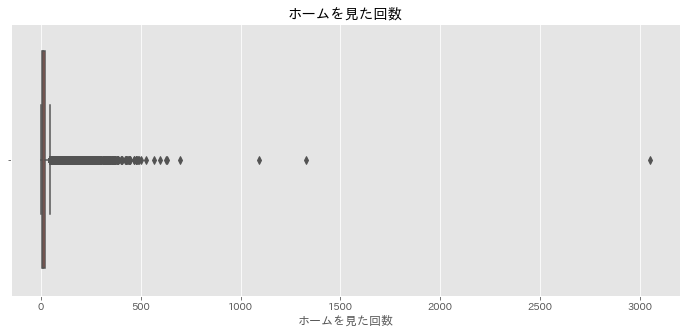

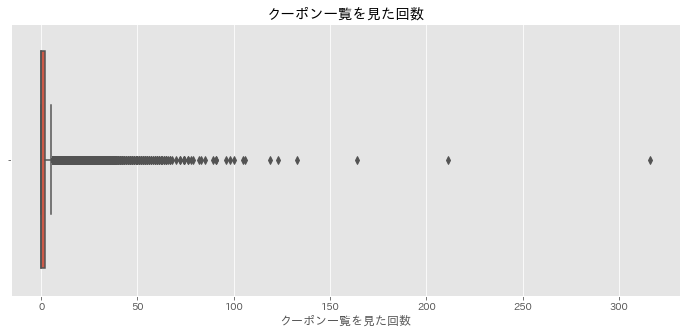

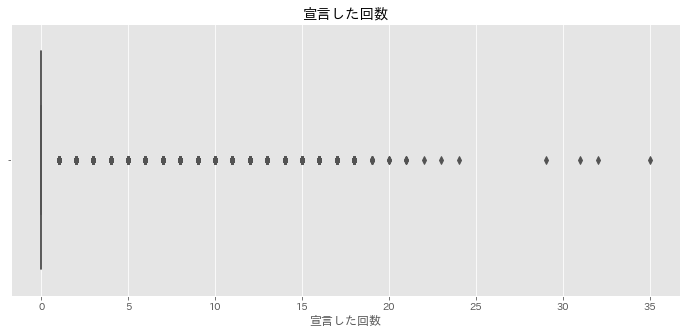

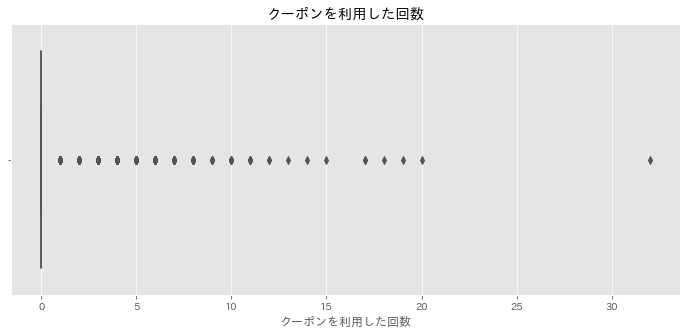

In [90]:
# 
display(df_data.describe())
plt.figure(figsize=(12,5))
plt.title("ホームを見た回数")
sns.boxplot(df_data["ホームを見た回数"])
# display(df_data.query("ホームを見た回数>=1")[["ホームを見た回数"]].describe())

plt.figure(figsize=(12,5))
plt.title("クーポン一覧を見た回数")
sns.boxplot(df_data["クーポン一覧を見た回数"])
# display(df_data.query("クーポン一覧を見た回数>=1")[["クーポン一覧を見た回数"]].describe())

plt.figure(figsize=(12,5))
plt.title("宣言した回数")
sns.boxplot(df_data["宣言した回数"])
# display(df_data.query("宣言した回数>=1")[["宣言した回数"]].describe())

plt.figure(figsize=(12,5))
plt.title("クーポンを利用した回数")
sns.boxplot(df_data["クーポンを利用した回数"])
# display(df_data.query("クーポンを利用した回数>=1")[["クーポンを利用した回数"]].describe())

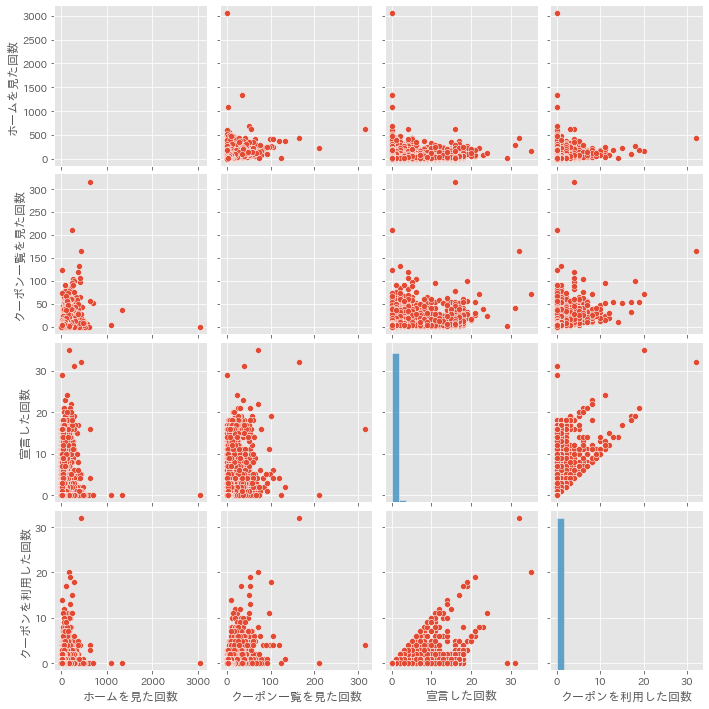

In [66]:
sns.pairplot(df_data[["ホームを見た回数","クーポン一覧を見た回数","宣言した回数","クーポンを利用した回数"]])

In [106]:
for i in df_data.columns:
    df_de = df_data.query("lifestage=='DEWKS'")[[i]].describe()
    df_de.columns=["DEWKS"]
    df_di = df_data.query("lifestage=='DINKS'")[[i]].describe()
    df_di.columns=["DINKS"]
    df_t = df_data.query("lifestage=='単身'")[[i]].describe()
    df_t.columns=["単身"]
    df_r = df_data.query("lifestage=='老年夫婦'")[[i]].describe()
    df_r.columns=["老年夫婦"]
    df_f = df_data.query("lifestage=='不明'")[[i]].describe()
    df_f.columns=["不明"]
    df_result = pd.concat([df_de, df_di, df_t, df_r, df_f],axis=1)

In [108]:
i

'クーポンを利用した回数'

In [107]:
df_result

,DEWKS,DINKS,単身,老年夫婦,不明
count,120883.000000,108536.000000,79120.000000,85021.000000,43949.000000
mean,0.033090,0.026406,0.024242,0.013620,0.000091
std,0.261934,0.235009,0.267359,0.175352,0.009540
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.000000,18.000000,32.000000,19.000000,1.000000


,sex,age,ホームを見た回数,クーポン一覧を見た回数,宣言した回数,クーポンを利用した回数
count,437509.000000,437509.000000,437509.00000,437509.000000,437509.000000,437509.000000
mean,1.608342,100.825078,16.45797,1.536343,0.141675,0.022733
std,2.976487,227.360904,22.63804,2.951443,1.023562,0.227310
min,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
25%,0.000000,35.000000,4.00000,0.000000,0.000000,0.000000
50%,1.000000,45.000000,10.00000,0.000000,0.000000,0.000000
75%,1.000000,55.000000,20.00000,2.000000,0.000000,0.000000
max,9.000000,999.000000,3051.00000,316.000000,35.000000,32.000000


<AxesSubplot:title={'center':'クーポンを利用した回数'}, xlabel='lifestage', ylabel='クーポンを利用した回数'>

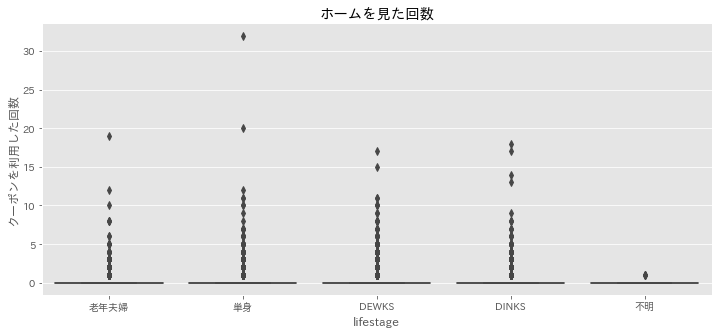

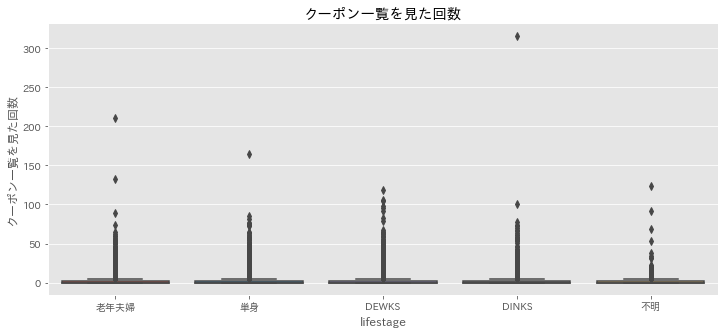

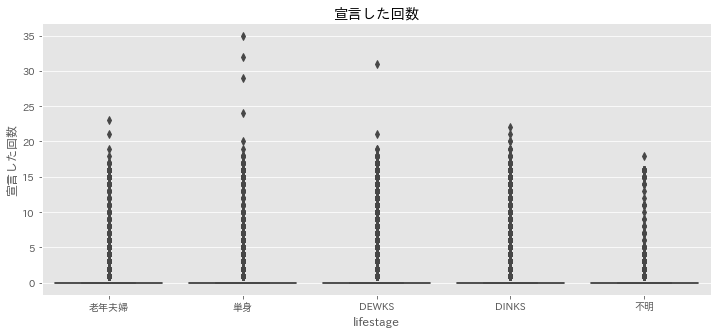

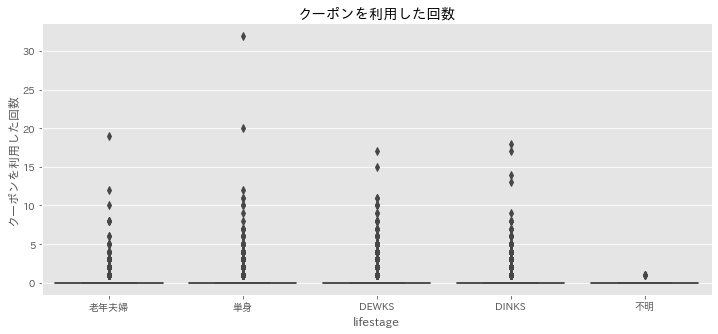

In [77]:
plt.figure(figsize=(12,5))
plt.title("ホームを見た回数")
sns.boxplot(data = df_data,x="lifestage",y="クーポンを利用した回数")

plt.figure(figsize=(12,5))
plt.title("クーポン一覧を見た回数")
sns.boxplot(data = df_data,x="lifestage",y="クーポン一覧を見た回数")


plt.figure(figsize=(12,5))
plt.title("宣言した回数")
sns.boxplot(data = df_data,x="lifestage",y="宣言した回数")

plt.figure(figsize=(12,5))
plt.title("クーポンを利用した回数")
sns.boxplot(data = df_data,x="lifestage",y="クーポンを利用した回数")